# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import keras

import numpy as np
import bayesflow as bf

from numba import njit

np.set_printoptions(suppress=True)

ERROR:2025-10-25 21:33:30,962:jax._src.xla_bridge:502: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/geraldine/Documents/Research/Projects/TogetherFlow/.venv/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 500, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/geraldine/Documents/Research/Projects/TogetherFlow/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/geraldine/Documents/Research/Projects/TogetherFlow/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_UNKNOWN
ERROR:jax._src.xla_bridge:Ja

In [3]:
bf.__version__

'2.0.7'

In [4]:
from togetherflow.old.boundary_conditions import bound_agent_position
from togetherflow.old.priors import complete_pooling_prior

## Generative Model Definition

The movement of any agent $a = 1, ..., A$ is both related to: 1) its interaction with surrounding neighbors $i = 1, ..., I$, which we call *internal influence*, and 2) their motivation to the surrounding spatial objects $b = 1, ..., B$, which we call *external influence*. These influences are modulated by a stationary weight, $w_a$:

\begin{equation}
    \theta_{a, t} = w_a \theta_{a|j, t} + (1 - w_a) \theta_{a|i, t}.
\end{equation}

### Meta-Variables

First, we define some meta-variables, such as the number of agents to simulate, the number of spatial beacons present in the environment, etc.

In [5]:
num_agents = 12
num_beacons = 2
room_size = (8., 10.)
world_size = 25.

### Agent Initialization

First, we initialize the agents with a randomized position and orientation, both uniformly distributed.

In [6]:
@njit
def initialize_agents(
    num_agents: int = 12, 
    room_size: tuple = (8., 10.),
):
    """
    Generate random positions and orientations for agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100.0).

    Returns
    -------
    tuple of np.ndarray
        A tuple containing the positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    # Generate random positions within the boundary size centered at 0
    x = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[0]
    y = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[1]
    positions = np.vstack((x, y)).T
    
    # Generate random orientations (angles in radians between 0 and 2*pi)
    rotations = np.random.random(size=(num_agents, )).astype(np.float32) * np.pi * 2
    
    return positions.astype(np.float32), rotations.astype(np.float32)

In [7]:
agent_positions, agent_rotations = initialize_agents(room_size=room_size, num_agents=12)
agent_positions[0]

array([-3.9648194 , -0.59737176], dtype=float32)

### Beacon initialization

To intrinsically motivate the agents, we need a set of virtual beacons that are populated within the environment. The beacons have a freer representation with only positions needed.

In [8]:
@njit
def initialize_beacons(
        num_beacons = 10,
        room_sensing_range = 50.
):
    
    """
    Initialize beacons following a uniform distribution scaled to the room's sensing boundary
    
    Parameters
    ----------
    num_beacons : int, default: 10
        Number of beacons to initialize.
    room_sensing_range : float, default: 50.0
        Sensing distance of the room for the beacons to matter.
    
    Returns 
    -------
    beacons      : np.ndarray of shape (num_beacons, 2)
        Initial positions of the beacons. 
    """
    
    beacons = (np.random.random(size=(num_beacons, 2)) - 0.5) * room_sensing_range
    return beacons.astype(np.float32)

In [9]:
beacon_positions = initialize_beacons(num_beacons=1, room_sensing_range=world_size)
beacon_positions

array([[-1.5186632, -0.6674628]], dtype=float32)

## External Influence: drift-diffusion vector

We want to compute the influence of agent movement direction within a single time step. For this, we specify our internal influence as a 2D drift diffusion model, where the agents are approach a spatial beacon within the room's boundary by reorienting its locomotive direction.

\begin{equation}
    \theta_{a|j, t} = \theta_{a|j, t-1} + \omega_a \mathrm{d}t + \mathrm{d}\phi_t,
\end{equation}

\begin{align}
    \mathrm{d}\mathbf{x}_{a|j, t} 
    &= v_{a|j}\mathrm{d}t \frac{\mathbf{x}_{a|j}}{||\mathbf{x}_{a|j}||} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t \\
    &= v_{a}\mathrm{d}t     
    \begin{bmatrix}
        \cos \theta_{a|j, t} \\
        \sin \theta_{a|j, t}
    \end{bmatrix} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t,% \sqrt{\mathrm{d}t} Z_t.
\end{align}

In [10]:
@njit
def external_influence( 
    agent_position,
    beacon_position,
    noise = False,
    noise_amplitude = 0.01
):
    """
    Generate a drift-diffusion vector in 2D space for a single agent 
    based on a target location (in this case, the position of a beacon).

    Parameters
    ----------
    agent_position : np.ndarray
        The position of the agent.
    target_position : np.ndarray
        The position of the target beacon.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.
    noise: bool, optional
        Whether the focus is interpreted as noise amplitude.

    Returns
    -------
    np.ndarray
        A 2D vector representing the drift-diffusion process towards the target (beacon).
    """
    # Calculate the angle towards the beacon (in radian)
    beacon_direction = np.arctan2(
        beacon_position[1] - agent_position[1], 
        beacon_position[0] - agent_position[0]
    )
    
    # Generate a random direction with drift around the target angle
    if noise:
        beacon_direction = beacon_direction + (np.random.random() - 0.5) * noise_amplitude
        # beacon_direction = beacon_direction + np.random.vonmises(0., 8.) * noise_amplitude
    
    # Convert the angle to a unit vector in 2D space
    v = np.array([np.cos(beacon_direction), np.sin(beacon_direction)], dtype=np.float32)
    
    return v

## Internal Influence: particle dynamics

Its influence by a collective group of agents is modeled as a self-propelling particle system, as expressed in the Vicsek model:

\begin{align}
    \theta_{a|i, t} &= \langle \theta_{i, t}\rangle_{|\mathbf{x}_a - \mathbf{x}_i| < r_a, i \in I} + \eta_{a,t-1}, \\
    \mathrm{d} \mathbf{x}_{a|i,t} &= v_{a,t} \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a|i, t} \\
        \sin \theta_{a|i, t}
    \end{bmatrix},
\end{align}

In [11]:
@njit 
def internal_influence(
    self_position,
    other_positions,
    other_rotations,
    sensing_radius = 1.5,
    focus = 0.01,
    noise = False
):
    """
    Generate an influence vector for a single agent 
    based on the angular component of the Vicsek model.

    Parameters
    ----------
    self_position : np.ndarray of shape (2,)
        A 2D vector representing the position of the agent
    other_positions : np.ndarray of shape (2,)
        A 2D vector representing the positions of the neighboring agents.
    other_rotations : np.ndarray of shape (2,)
        A 2D vector representing the rotations of the neighboring agents.
    sensing_radius : float
        The sensing radius within which agents interact with their neighbors.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.
    noise: bool, optional
        Whether the focus is interpreted as noise amplitude.

    Returns
    -------
    np.ndarray
        A 2D unit vector representing the averaged influence direction with added noise.
    """
      
    neighbor_rotations = []
    
    for i in range(len(other_positions)):
        dx = other_positions[i, 0] - self_position[0]
        dy = other_positions[i, 1] - self_position[1]
        d = (dx ** 2 + dy ** 2) ** 0.5
        
        if d <= sensing_radius and d > 0:
            neighbor_rotations.append(other_rotations[i])
        
    if len(neighbor_rotations) == 0:
        return np.array([0.0, 0.0], dtype=np.float32)
    
    neighbor_rotations = np.array(neighbor_rotations)
    averaged_rotation = np.sum(neighbor_rotations) / len(neighbor_rotations)
    
    if noise:
        deviation = (np.random.random() - 0.5) * focus
    else:
        deviation = np.random.vonmises(mu=0., kappa=4.) * focus
    direction = averaged_rotation + deviation
    
    v = np.array([np.cos(direction), np.sin(direction)], dtype=np.float32) 
    
    return v

In [12]:
deviation = np.random.vonmises(mu=0., kappa=4.) * 1
deviation

0.9027043861909396

## Putting everything together: combined influences

The combined influences allow us to update the agents' positions and rotations together.

In [13]:
@njit
def count_neighbors(self_position, other_positions, sensing_radius = 1.5):
    """
    Helper function that counts the number of neighbors
    
    Parameters
    ----------
    self_position   : np.ndarray of size (2)
        The position of the agent itself
    other_positions : np.ndarray of size (num_agents, 2)
        The positions of all agents
    sensing_radius  : float, default: 1.5
        The sensing radius of the agent
        
    Returns 
    -------
    num_neighbors   : int, default: 0
        The number of neighbors within the agent's sensing radius.
    """
    
    num_neighbors = 0
    
    for i in range(len(other_positions)):
        dx = other_positions[i, 0] - self_position[0]
        dy = other_positions[i, 1] - self_position[1]
        d = (dx ** 2 + dy ** 2) ** 0.5
        
        if d <= sensing_radius and d > 0:
            num_neighbors += 1

    return num_neighbors

In [14]:
num_neighbors = count_neighbors(agent_positions[8], agent_positions)
num_neighbors

1

In [15]:
@njit
def combined_influences(
    agent_positions: np.ndarray = None, 
    agent_rotations: np.ndarray = None,
    beacon_positions: np.ndarray = None,
    velocity: float = 1.0, 
    sensing_radius: float = 2.5,
    dt: float = 0.1, 
    influence_weight: float = 0.5,
    internal_focus: float = 0.1
):
    """
    Update the positions and orientations of a single agent 
    based on velocity and influence vectors.

    Parameters
    ----------
    agent_positions : np.ndarray
        Current positions of the agents.
    agent_rotations : np.ndarray
        Current orientations of the agents.
    beacon_positions : np.ndarray
        Positions of the beacons.
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    sensing_radius : float, optional
        The sensing radius within which agents interact with their neighbors.
    dt : float, optional
        The time step for updating positions and orientations (default is 0.1).
    influence_weight : float, optional
        The weight of influence_vector1 in determining new orientations (default is 0.7).
    external_focus : float, optional
        Concentration of the agent's rotational noise influenced by the beacons
    internal_focus : float, optional
        Concentration of the agent's rotational noise influenced by the neighbors

    Returns
    -------
    tuple of np.ndarray
        Updated positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    assert (len(agent_positions) == len(agent_rotations))
    
    num_agents = agent_positions.shape[0]
    num_beacons = beacon_positions.shape[0]
    
    # Create new numpy arrays for the updated agent positions and rotations
    new_agent_positions = np.zeros((num_agents, 2))
    new_agent_rotations = np.zeros((num_agents, ))
    num_neighbors = np.zeros((num_agents, ))
    
    
    for i in range(num_agents):
        
        num_neighbors[i] = count_neighbors(agent_positions[i], agent_positions)
        
        # Generate the ddm vector for the agent based on its closest beacon
        distance_to_beacon = []
        
        for b in range(num_beacons):
            bx = beacon_positions[b, 0] - agent_positions[i, 0]
            by = beacon_positions[b, 1] - agent_positions[i, 1]
            distance_to_beacon.append((bx * bx + by * by) ** 0.5)
        
        beacon_id = np.argmin(np.array(distance_to_beacon))
        
        ddm_vector = external_influence(
            agent_positions[i], 
            beacon_positions[beacon_id],
            #focus=external_focus
        )
        
        # Generate the vicsek vector for the agent based on its neighbors (all agents)
        vicsek_vector = internal_influence(
            self_position=agent_positions[i],
            other_positions=agent_positions,
            other_rotations=agent_rotations,
            sensing_radius=sensing_radius,
            focus=internal_focus
        )

        # Update orientations based on two influence vectors
        ddm_influence = np.arctan2(ddm_vector[1], ddm_vector[0])
        vicsek_influence = np.arctan2(vicsek_vector[1], vicsek_vector[0])
        
        # Combine influences to update orientations with different weights
        new_agent_rotations[i] = agent_rotations[i] + (influence_weight * ddm_influence + (1 - influence_weight) * vicsek_influence) * dt
        
        # Ensure orientations are within the range [0, 2*pi]
        new_agent_rotations[i] = np.mod(new_agent_rotations[i], 2 * np.pi)
        
        # Update positions based on current orientations
        new_agent_positions[i, 0] = agent_positions[i, 0] + velocity * np.cos(new_agent_rotations[i].item()) * dt
        new_agent_positions[i, 1] = agent_positions[i, 1] + velocity * np.sin(new_agent_rotations[i].item()) * dt
        
        new_agent_positions[i] = bound_agent_position(new_agent_positions[i], room_size=room_size)
    
    return new_agent_positions, new_agent_rotations, num_neighbors

In [16]:
agent_positions, agent_rotations = initialize_agents(12, room_size=room_size)
beacon_positions = initialize_beacons(num_beacons=2)
new_agent_positions, new_agent_rotations, num_neighbors = combined_influences(agent_positions, agent_rotations, beacon_positions)

In [17]:
np.concatenate([agent_positions, new_agent_positions], axis=1)

array([[ 2.52313328, -2.09152961,  2.43085484, -2.13006128],
       [ 1.33557701, -2.82196164,  1.40260141, -2.74774756],
       [ 3.28188086, -4.15655279,  3.35514436, -4.08849062],
       [ 1.73955202, -3.75920534,  1.82972903, -3.80242694],
       [ 3.99747658,  2.2531414 ,  3.89780277,  2.26121184],
       [-1.67648268,  2.70126295, -1.65454612,  2.79882722],
       [ 0.67077398,  0.17712891,  0.72193085,  0.09120467],
       [ 1.36118555,  2.92961407,  1.42562199,  2.85314221],
       [-0.59274554,  2.89030504, -0.6467831 ,  2.97444744],
       [ 0.67003441, -4.31412745,  0.70728896, -4.40692884],
       [-2.99331379, -0.06130487, -3.07987261, -0.01122922],
       [-1.46943998, -1.9638381 , -1.45559885, -1.86480062]])

In [18]:
np.vstack([agent_rotations, new_agent_rotations]).T

array([[3.25703454, 3.53714372],
       [0.81045896, 0.83625877],
       [0.74653405, 0.74861085],
       [5.58803415, 5.83623657],
       [3.21653676, 3.06080045],
       [1.34782732, 1.34963218],
       [5.10662746, 5.24939847],
       [5.44065809, 5.41258087],
       [2.40590668, 2.14167968],
       [5.12718201, 5.09413952],
       [2.40990758, 2.61712019],
       [1.16393518, 1.43193916]])

In [19]:
num_neighbors

array([1., 2., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0.])

## Simulation Loop

The update allows us to continuously simulate the agents' positions and rotations at a given interval

In [20]:
@njit
def simulator_fun(
    theta = None,
    num_agents: int = 12, 
    num_beacons: int = 1,
    room_size: tuple = (8, 10),
    velocity: float = 1.0, 
    dt: float = 0.001, 
    influence_weight: float = 0.7, 
    sensing_radius: float = 10.0,
    internal_focus: float = 0.1,
    time_horizon: float = 30.
):
    """
    Run the simulation and store the time series of positions and orientations of agents.

    Parameters
    ----------
    theta : np.ndarray
        Prior parameters specifying the internal properties of the agents
    num_agents : int, optional
        Number of agents to generate (default is 100).
    num_beacons : int, optional
        Number of beacons to generate (default is 1).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100).
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    dt : float, optional
        The time step for the update (default is 0.1).
    influence_weight : float, optional
        The weight for influence_vector1 in determining new orientations (default is 0.7).
    sensing_radius : float, optional
        The sensing radius for the Vicsek model (default is 10.0).
    num_timesteps : int, optional
        The number of steps to simulate (default is 100).

    Returns
    -------
    tuple of np.ndarray
        The time series of positions and orientations of the agents.
    """
    
    if theta is not None:
        influence_weight = theta[0]
        sensing_radius = theta[1]
        velocity = theta[2]
        #internal_focus = theta[3]
    
    
    num_timesteps = int(time_horizon / dt)

    # Apply radial bound with sigmoid transformation for the sensing radius
    # (r_min, r_max) = (1., 5.)
    # sensing_radius = r_min + (r_max - r_min) * (1. / (1. + np.exp(-sensing_radius)))
    
    # Initialize positions and orientations
    initial_positions, initial_rotations = initialize_agents(num_agents, room_size=room_size)

    # Initialize arrays to store time series of positions and orientations
    positions = np.zeros((num_timesteps, num_agents, 2))
    rotations = np.zeros((num_timesteps, num_agents, ))
    neighbors = np.zeros((num_timesteps, num_agents, ))
    positions[0] = initial_positions
    rotations[0] = initial_rotations
    
    # Initialize beacons
    beacon_positions = initialize_beacons(num_beacons)

    # Simulation loop
    for t in range(1, num_timesteps):
        ps, rs, num_neighbors = combined_influences(
            agent_positions=positions[t-1], 
            agent_rotations=rotations[t-1], 
            beacon_positions=beacon_positions, 
            velocity=velocity, 
            sensing_radius=sensing_radius, 
            dt=dt, 
            influence_weight=influence_weight,
            internal_focus=internal_focus
        )
        
        # Store positions and orientations for each time step
        positions[t] = ps
        rotations[t] = rs
        neighbors[t] = num_neighbors
    
    neighbors[0] = neighbors[1]    
    
    rotations = rotations[:,:,np.newaxis]
    neighbors = neighbors[:,:,np.newaxis]

    return np.concatenate((positions, rotations, neighbors), axis=-1)

In [21]:
simulation = simulator_fun(num_agents=49)
simulation[:,:,-1]

array([[3., 5., 5., ..., 3., 4., 3.],
       [3., 5., 5., ..., 3., 4., 3.],
       [3., 5., 5., ..., 3., 4., 3.],
       ...,
       [6., 0., 0., ..., 4., 5., 1.],
       [6., 0., 0., ..., 4., 5., 1.],
       [6., 0., 0., ..., 4., 5., 1.]])

In [45]:
class TogetherFlowSimulator:

    def __init__(self,
                 num_agents: int = 12,
                 num_beacons: int = 1,
                 room_size: tuple = (8, 10),
                 dt: float = 0.001,
                 internal_focus: float = 0.1,
                 time_horizon: float = 30.,
                 downsample: bool = True,
                 downsample_factor: int = 1
                 ):
        self.num_agents = num_agents
        self.num_beacons = num_beacons
        self.room_size = room_size
        self.dt = dt
        self.internal_focus = internal_focus
        self.time_horizon = time_horizon
        self.downsample = downsample
        self.downsample_factor = downsample_factor
        self.num_timesteps = int(time_horizon / dt)


    def sample(self, batch_shape: int | tuple = (1,)) -> dict[str, np.ndarray]:

        batch_size = batch_shape[0]
        thetas = []
        samples = []

        for i in range(batch_size):
            theta = complete_pooling_prior()
            sim = simulator_fun(
                theta=theta,
                num_agents=self.num_agents,
                num_beacons=self.num_beacons,
                room_size=self.room_size,
                dt=self.dt,
                internal_focus=self.internal_focus,
                time_horizon=self.time_horizon
            )
            thetas.append(theta)
            samples.append(sim)

        thetas = np.array(thetas)
        samples = np.array(samples)

        if self.downsample:
            samples = samples[:,::self.downsample_factor,:,:]

        B, T, A, D = samples.shape

        positions = samples[:,:,:,0:2].reshape((B, T, A*2))
        rotations = samples[:,:,:,2].reshape((B, T, A))
        neighbors = samples[:,:,:,3].reshape((B, T, A))

        return dict(
            w = thetas[:,0][..., None],
            r = thetas[:,1][..., None],
            v = thetas[:,2][..., None],
            positions = positions,
            rotations = rotations,
            neighbors = neighbors
        )

In [78]:
simulator = TogetherFlowSimulator(num_agents=49, dt=0.01, time_horizon=100.)
test_sims = simulator.sample(batch_shape=(10,))

print(test_sims['w'].shape)
print(test_sims['r'].shape)
print(test_sims['v'].shape)
print(test_sims['positions'].shape)
print(test_sims['rotations'].shape)
print(test_sims['neighbors'].shape)

(10, 1)
(10, 1)
(10, 1)
(10, 1000, 98)
(10, 1000, 49)
(10, 1000, 49)


## Adapter

In [56]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series(["positions", "rotations", "neighbors"])
    .concatenate(['w', 'r', 'v'], into="inference_variables")
    .concatenate(["positions", "rotations", "neighbors"], into="summary_variables", axis=-1)
)

In [57]:
adapted_simulator = TogetherFlowSimulator(num_agents=49, dt=0.1, time_horizon=100.)
adapter_sim = adapter(adapted_simulator.sample(batch_shape=(10,)))

In [58]:
print(adapter_sim['summary_variables'].shape)
print(adapter_sim['inference_variables'].shape)

(10, 100, 196)
(10, 3)


# Neural Approximator

In [70]:
# This one generalizes over different numbers of agents

class SummaryNet(keras.Model):

    def __init__(self, base):
        super().__init__()
        self.base = base

    def build(self, input_shape):
        self.base.build(input_shape)
        super().build(input_shape)  # marks self.built = True

    def call(self, x, training: bool=False):
        return self.base(x, training=training)

    def compute_output_shape(self, input_shape):
        return self.base.compute_output_shape(input_shape)

    def compute_metrics(self, inputs, *, stage: str | None = None, sample_weight=None, **kwargs):
        training_flag = (stage == "training")
        outputs = self(inputs, training=training_flag)
        # Zero dummy loss so the API is satisfied
        loss = keras.ops.zeros(())
        return {"loss": loss, "outputs": outputs}


summary_net = SummaryNet(keras.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=2, strides=2, activation="elu"),
    keras.layers.Conv1D(filters=32, kernel_size=2, strides=2, activation="elu"),
    keras.layers.LSTM(512),
    keras.layers.Dense(64)
]))

In [60]:
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(64, dropout=0.1)
        self.summary_stats = keras.layers.Dense(8)

    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        return summary

In [71]:
# summary_net = GRU()
inference_net = bf.networks.DiffusionModel()

In [81]:
workflow = bf.workflows.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net
)

In [ ]:
training_set = workflow.simulate((1000,))
validation_set = workflow.simulate((50,))

In [80]:
training_set['neighbors'].shape

(1000, 100, 49)

In [74]:
history = workflow.fit_offline(
    data=training_set,
    validation_data=validation_set,
    batch_size=64,
    epochs=100
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - loss: 9.1731 - loss/inference_loss: 9.1731 - loss/summary_loss: 0.0000e+00 - val_loss: 4.9520 - val_loss/inference_loss: 4.9520 - val_loss/summary_loss: 0.0000e+00
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 4.3845 - loss/inference_loss: 4.3845 - loss/summary_loss: 0.0000e+00 - val_loss: 3.3848 - val_loss/inference_loss: 3.3848 - val_loss/summary_loss: 0.0000e+00
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 2.4729 - loss/inference_loss: 2.4729 - loss/summary_loss: 0.0000e+00 - val_loss: 3.1472 - val_loss/inference_loss: 3.1472 - val_loss/summary_loss: 0.0000e+00
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 3.1737 - loss/inference_loss: 3.1737 - loss/summary_loss: 0.0000e+00 - val_loss: 2.4348 - val_loss/inference_loss: 2.4348 - val_loss/summary_loss: 0.0000e+00
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 2.2107 - loss/inference_loss: 2.2107 - loss/summary_loss: 0.0000e+0

In [75]:
samples = workflow.sample(num_samples=50, conditions=validation_set)

In [76]:
for k, v in samples.items():
    print(samples[k].shape)

(50, 50, 1)
(50, 50, 1)
(50, 50, 1)


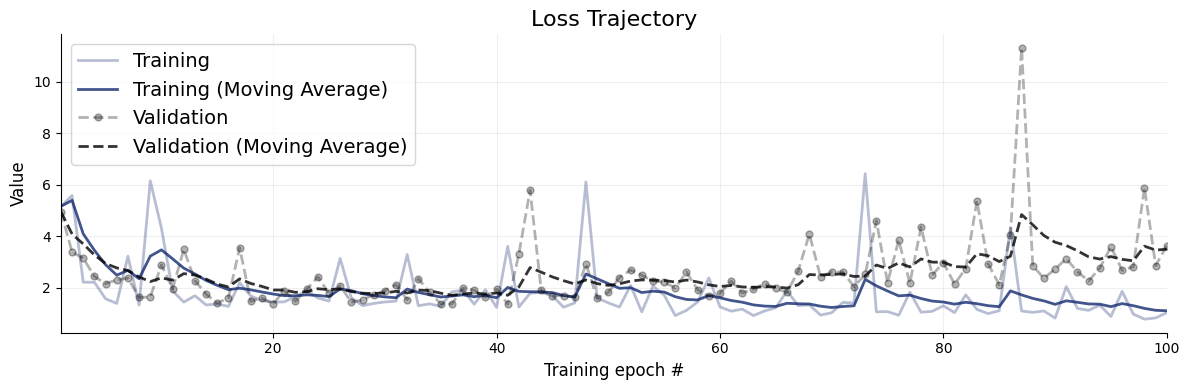

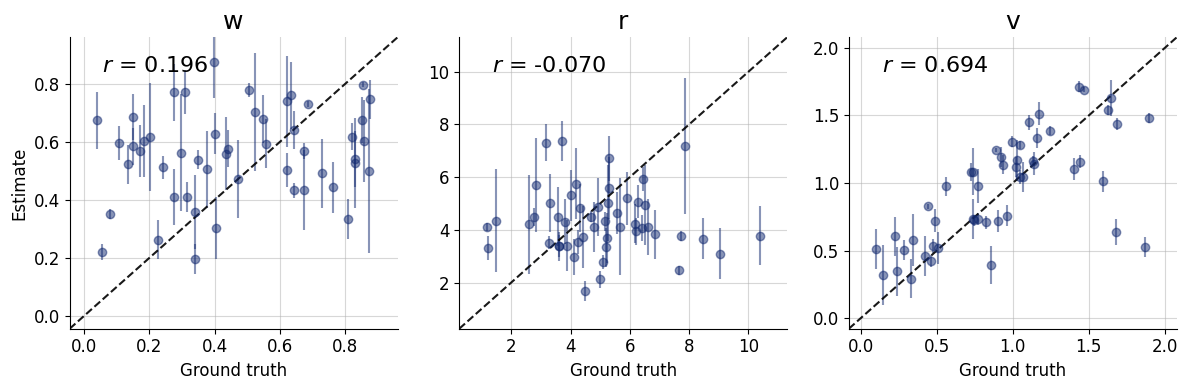

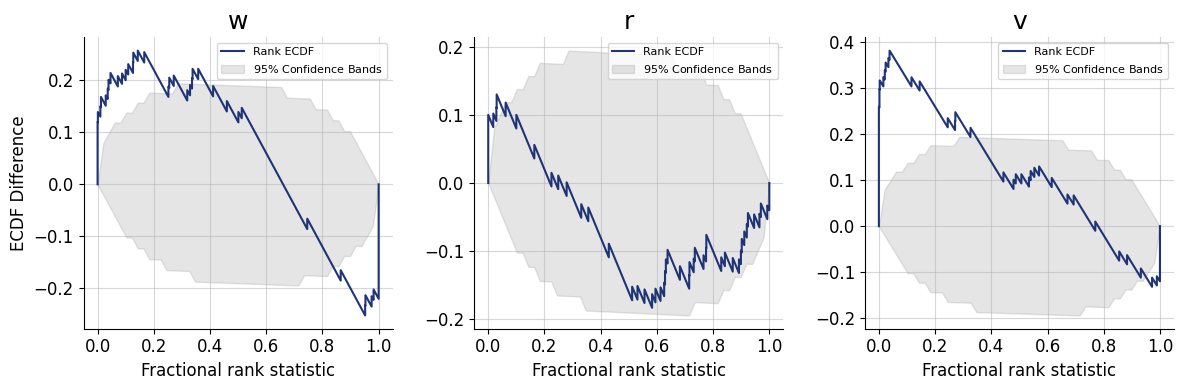

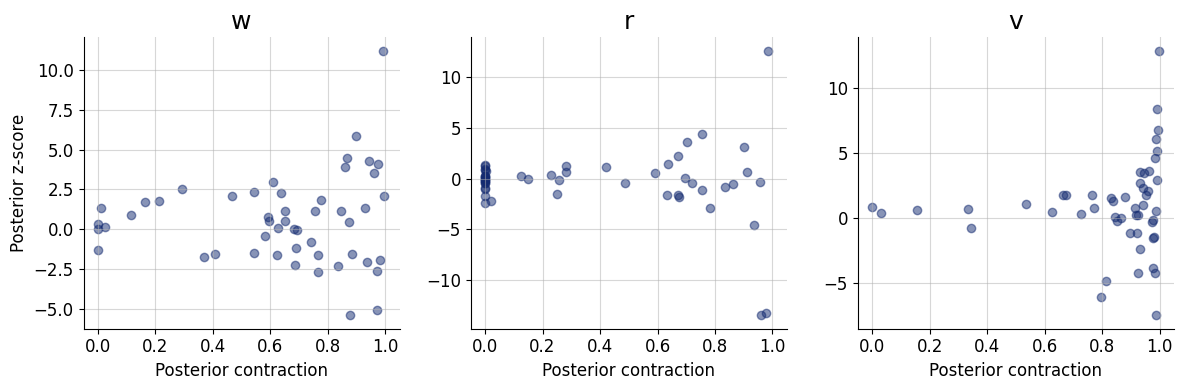

In [77]:
fig_size = (12, 4)

figures = workflow.plot_default_diagnostics(
    test_data=validation_set,
    variable_names=["w", "r", "v"],
    loss_kwargs={"figsize": fig_size, "label_fontsize": 12},
    recovery_kwargs={"figsize": fig_size, "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": fig_size, "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": fig_size, "label_fontsize": 12}
)